In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/home/lam/anaconda2/envs/tf15/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import numpy as np 
import pandas as pd 

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

fashion-mnist_test.csv
fashion-mnist_train.csv
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte



In [3]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data_train = pd.read_csv('input/fashion-mnist_train.csv')
data_test = pd.read_csv('input/fashion-mnist_test.csv')

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

In [4]:
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# seq = iaa.Sequential([iaa.Fliplr(0.5), sometimes(iaa.Affine(rotate=(-5, 5), shear=(-5, 5)))])
seq = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 0.5))])
X_train = seq.augment_images(X_train)

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

batch_size = 256
num_classes = 10
epochs = 50

#input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# load or start from scratch
# model.load_weights("v4.3.5_ia/weights-improvement-04-0.94.hdf5")

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [6]:
from keras.callbacks import ModelCheckpoint
import os

outpath = "v4.3.6_ia"
if not os.path.exists(outpath):
    os.mkdir(outpath)
filepath= outpath + "/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 128)         512       
__________

In [8]:
model.metrics_names

['loss', 'acc']

### Training
Let's `fit()`! Note that `fit()` will return a _History_ object which we can use to plot training vs. validation accuracy and loss.

In [9]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val), callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.0429 - acc: 0.9849 - val_loss: 0.2301 - val_acc: 0.9366

Epoch 00001: val_acc improved from -inf to 0.93658, saving model to v4.3.6_ia/weights-improvement-01-0.94.hdf5
Epoch 2/50
48000/48000 [==============================] - 12s 258us/step - loss: 0.0437 - acc: 0.9837 - val_loss: 0.2303 - val_acc: 0.9372

Epoch 00002: val_acc improved from 0.93658 to 0.93717, saving model to v4.3.6_ia/weights-improvement-02-0.94.hdf5
Epoch 3/50
48000/48000 [==============================] - 13s 268us/step - loss: 0.0401 - acc: 0.9853 - val_loss: 0.2344 - val_acc: 0.9348

Epoch 00003: val_acc did not improve
Epoch 4/50
48000/48000 [==============================] - 13s 264us/step - loss: 0.0397 - acc: 0.9859 - val_loss: 0.2337 - val_acc: 0.9359

Epoch 00004: val_acc did not improve
Epoch 5/50
48000/48000 [==============================] - 13s 262us/step - loss: 0.0415 - a

In [10]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2599919076454826
Test accuracy: 0.9408


In [11]:
# weights
from glob import glob
g = glob(outpath + '/*')

for wt in g:
    model.load_weights(wt)
    score = model.evaluate(X_test, y_test, verbose=0)
    print(wt)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

v4.3.6_ia/weights-improvement-02-0.94.hdf5
Test loss: 0.22287949445862323
Test accuracy: 0.9395
v4.3.6_ia/weights-improvement-01-0.94.hdf5
Test loss: 0.2227213383153081
Test accuracy: 0.9399
v4.3.6_ia/weights-improvement-11-0.94.hdf5
Test loss: 0.23412770001962782
Test accuracy: 0.9403
v4.3.6_ia/weights-improvement-12-0.94.hdf5
Test loss: 0.2325759808738716
Test accuracy: 0.9414


### Results


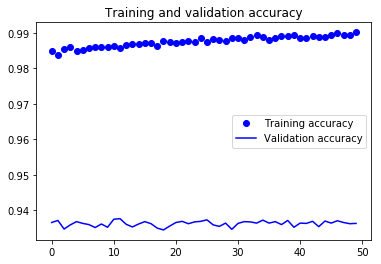

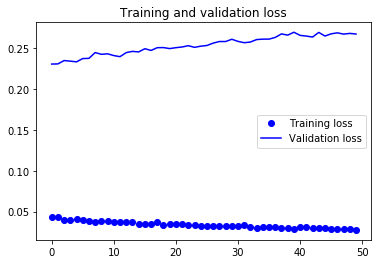

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Classification Report

In [13]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [14]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.92      0.89      0.90      1000
    Class 1       1.00      0.99      0.99      1000
    Class 2       0.93      0.91      0.92      1000
    Class 3       0.94      0.96      0.95      1000
    Class 4       0.93      0.90      0.92      1000
    Class 5       0.99      0.98      0.99      1000
    Class 6       0.80      0.85      0.83      1000
    Class 7       0.96      0.97      0.96      1000
    Class 8       0.99      0.99      0.99      1000
    Class 9       0.97      0.97      0.97      1000

avg / total       0.94      0.94      0.94     10000

